In [2020]:
import numpy as np

# Define generative model

The signal timesries $Y$ of of voxel $m$ is given by

$Y_m = \beta_{1,m} X_1 + \beta_{2,m} X_2 + \beta_{1,m} \eta_1 + \beta_{2,m}\eta_2 + \epsilon_m $
 
 Where:
  * $X$ is a design matrix with in the first column how much the left eye is stimulates and in the 2nd column how    much the right eye is stimulated.
  * $\beta_{1,m}$ determines how much voxel $m$ shows activation when the left eye is stimulated
  * $\beta_{2,m}$ determines how much voxel $m$ shows activation when the right eye is stimulated  
  * $\eta_1$ Is the noise distribution of the _left eye_ with $\eta_1 \sim \mathcal{N}(0, \sigma_1)$
  * $\eta_2$ Is the noise distribution of the _right eye_ with $\eta_2 \sim \mathcal{N}(0, \sigma_2)$
  * $\epsilon_m$ Is the noise distribution of voxel $m$ with $\epsilon_m \sim \mathcal{N}(0, \tau_m)$

In [2021]:
class BinocularGenerativeModel:

    def __init__(self, n_voxels=100):
        
        self.n_voxels = n_voxels
        
        weights_left = np.random.randn(self.n_voxels)
        weights_right = 1 - weights_left
        weights_left -= .5
        weights_right -= .5
        
        weights_left *= np.random.randn(self.n_voxels)
        weights_right *= np.random.randn(self.n_voxels)
        
        self.weights = np.vstack((weights_left, weights_right))
        
        
    def simulate_data(self,
                      ocular_noise=1,
                      voxel_noise=1,
                      shared_noise=1,
                      X=None,
                      n_t=250):

        if X is None:
            X = np.tile(np.repeat([0, 1], 10), n_t // 20 + 1)[:n_t]
            X = np.vstack([X, (X-1) * -1]).T
    

    
        # We have noise that corresponds to the eyes
        ocular_noise = np.random.randn(n_t, 2) * ocular_noise
        
        # And we have noise that corresponds to the 
        measurement_noise = np.random.randn(n_t, self.n_voxels)

        data = (X + ocular_noise).dot(self.weights) + measurement_noise * voxel_noise
        
        data += np.random.randn(n_t)[:, np.newaxis] * shared_noise
        
        return data, X
        

        


Set up the simulation object

In [2022]:
bm = BinocularGenerativeModel()

## Simulate signal

We can now simulate a signal, where we have control over:
 * `ocular_noise`: The amount of noise that is shared between the left eye and right eye populations
 * `shared_noise`: The amount of noise that is equal over _all voxels_
 * `voxel_noies`: The amount of noise that is unique per voxel

In [2023]:
data, X = bm.simulate_data(n_t=255, ocular_noise=.1)

### Plot first 2 voxels

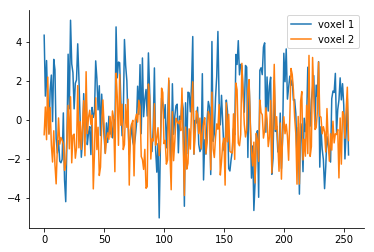

In [2024]:
plt.plot(data[:,0], label='voxel 1')
plt.plot(data[:,1], label='voxel 2')
plt.legend()
sns.despine()

As we can see, the noise in an individual voxel is substantial, although we can somewhat discern the general pattern of the design.

In [2025]:
import seaborn as sns

# Plots a weighted sum of voxels, depending on their eye-sensitivity

Here we plot a weighted sum of the voxels, depending on their ground-truth "eye-weight"

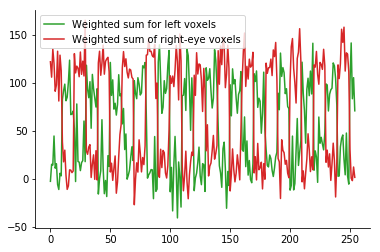

In [2026]:

plt.plot((bm.weights[0,:] * data).sum(1), label='Weighted sum for left voxels', color=sns.color_palette()[2])
plt.plot((bm.weights[1,:] * data).sum(1), label='Weighted sum of right-eye voxels', color=sns.color_palette()[3])
plt.legend()
sns.despine()

# Estimate weights using least squares

In [2028]:
import numpy as np

In [2029]:
beta, residuals, _, _ = np.linalg.lstsq(X, data)

/Users/gilles/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


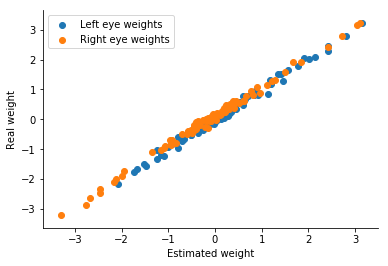

In [2030]:
plt.scatter(beta[0, :], bm.weights[0, :], label='Left eye weights')
plt.scatter(beta[1, :], bm.weights[1, :], label='Right eye weights')

plt.xlabel('Estimated weight')
plt.ylabel('Real weight')
plt.legend()
sns.despine()

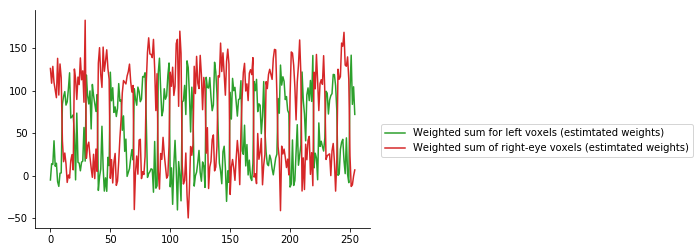

In [2031]:

plt.plot((beta[0,:] * data).sum(1), label='Weighted sum for left voxels (estimtated weights)', color=sns.color_palette()[2])
plt.plot((beta[1,:] * data).sum(1), label='Weighted sum of right-eye voxels (estimtated weights)', color=sns.color_palette()[3])
lgd = plt.gca().legend(loc=9, bbox_to_anchor=(1.5,.5))
# plt.legend()
sns.despine()

# Bayesian model inversion

In [1927]:
class BinocularModelFitter(object):
    
    def __init__(self):
        pass
    
    def fit(self, data, X):
        
        beta, residuals, _, _ = np.linalg.lstsq(X, data)
        self.W = beta.T
        tau_ = np.sqrt(residuals / (len(data) - 1))[:, np.newaxis]
                               
        def loglikelihood(data, X, W, rho, tau2, sigma2):    
            omega = rho * tau2 + \
                   (1 - rho) * np.identity(len(tau2)) * tau2 + \
                    sigma2 * self.W.dot(self.W.T)

            predicted_timecourse = X.dot(self.W.T)

            try:    
                dist = ss.multivariate_normal(mean=np.zeros(omega.shape[0]), cov=omega)
            except ValueError:
                return -1e9

            return np.sum(dist.logpdf(data - predicted_timecourse))
        
        def loglikelihood_wrapper(pars):    
    
            rho = pars[0]
            tau = pars[1:-1][:, np.newaxis]
            sigma2 = pars[-1:]

            tau2 = tau.dot(tau.T)

            ll = loglikelihood(data, X, self.W, rho, tau, sigma2)

            return -ll        
        
        bounds = [(.01, 0.99)] + zip([1e-6] * len(data), data.std(0)*1.1) + [(0, 1000)]
        x0 = np.array([0.01] + list(tau_) + [1.])
        
        pars = sp.optimize.minimize(loglikelihood_wrapper, x0=x0, bounds=bounds, )
        
        self.rho_ = pars.x[0]
        self.tau_ = pars.x[1:-1]
        self.tau2_ = self.tau_.dot(self.tau_.T)
        self.sigma2_ = pars.x[-1]
        
        
        self.omega_ = self.rho_ * self.tau2_ + \
                      (1 - self.rho_) * np.identity(len(self.tau_)) * self.tau2_ + \
                      self.sigma2_ * self.W.dot(self.W.T)        

        self.mv_norm = ss.multivariate_normal(mean=np.zeros(self.omega_.shape[0]), cov=self.omega_)
        
        
    def decode(self, data, stimulus_range=None):

        if stimulus_range is None:
            stimulus = np.linspace(-5, 5, 1000)
        else:
            stimulus = np.linspace(stimulus_range[0], stimulus_range[1], 1000)

        # n_timepoints x n_stimuli x n_stimulus_populations x n_voxels
        hypothetical_timeseries = (self.W.T[np.newaxis, :, :] * stimulus[:, np.newaxis, np.newaxis])
        residuals = data[:, np.newaxis, np.newaxis, :] - hypothetical_timeseries[np.newaxis, ...]

        # n_timepoints x n_stimuli x n_stimulus_populations
        p_ds = self.mv_norm.pdf(residuals)
        
        # Normalize
        p_ds /= p_ds.sum(1)[:, np.newaxis, :] * (stimulus[1] - stimulus[0])

        return stimulus, p_ds        
    
    
    def get_map_stimulus_timeseries(self, data, stimulus_range=None):
        s, p_ds = self.decode(data, stimulus_range)
        
        return s[p_ds.argmax(1)]

In [1584]:
import scipy as sp

In [1585]:
bm = BinocularGenerativeModel(n_voxels=25)
data, X = bm.simulate_data(n_t=1000, voxel_noise=1, ocular_noise=2, shared_noise=0)

In [1586]:
fitter = BinocularModelFitter()

fitter.fit(data, X)

/Users/gilles/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


# Check model recovery for $rho$

In [1588]:
fitter = BinocularModelFitter()

results = []
for shared_noise in [0, .5, 1, 5, 10]:
    print(shared_noise)
    for i in range(5):
        data, X = bm.simulate_data(n_t=250, voxel_noise=1, ocular_noise=2, shared_noise=shared_noise)
        fitter.fit(data, X)
        
        results.append({'shared_noise':shared_noise,
                        'run':i,
                        'sigma2':fitter.sigma2_,
                        'mean_tau':fitter.tau_.mean(),
                        'rho':fitter.rho_})

0


/Users/gilles/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


0.5
1
5
10


In [1589]:
import pandas as pd

In [1590]:
results = pd.DataFrame(results)

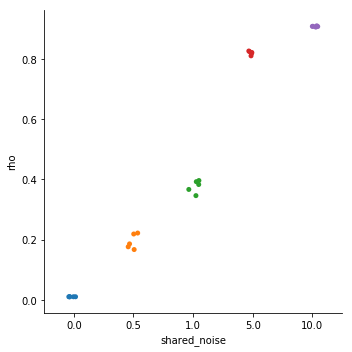

In [1591]:
sns.catplot('shared_noise', 'rho', data=results)

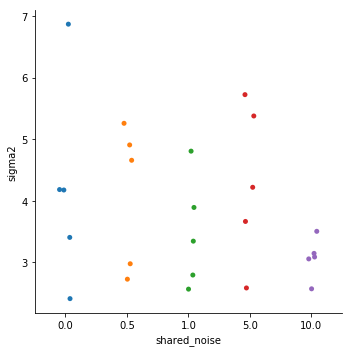

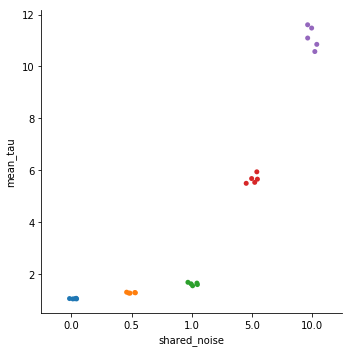

In [1594]:
sns.catplot('shared_noise', 'sigma2', data=results)
sns.catplot('shared_noise', 'mean_tau', data=results)

# Check model recovery for _sigma2_

In [1595]:
fitter = BinocularModelFitter()

results = []
for ocular_noise in [0, .5, 1, 5, 10]:
    print(ocular_noise)
    for i in range(5):
        data, X = bm.simulate_data(n_t=250, voxel_noise=1, ocular_noise=ocular_noise, shared_noise=0.1)
        fitter.fit(data, X)
        
        results.append({'ocular_noise':ocular_noise,
                        'run':i,
                        'sigma2':fitter.sigma2_,
                        'mean_tau':fitter.tau_.mean(),
                        'rho':fitter.rho_})

10


/Users/gilles/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


10
10
10
10


In [1596]:
results = pd.DataFrame(results)

In [1598]:
results['sigma'] = np.sqrt(results['sigma2'])

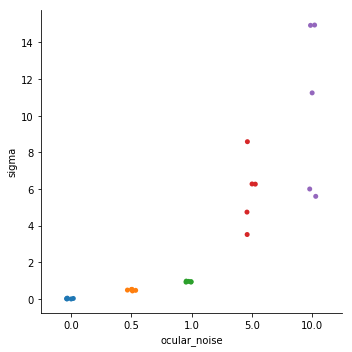

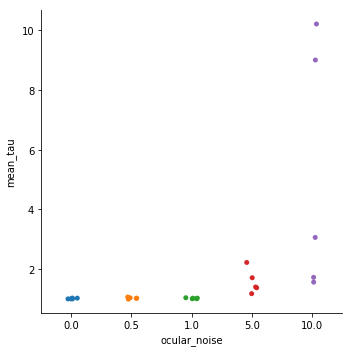

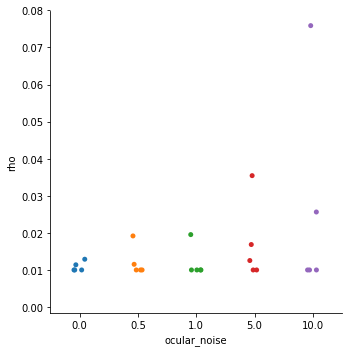

In [1599]:
sns.catplot('ocular_noise', 'sigma', data=results)
sns.catplot('ocular_noise', 'mean_tau', data=results)
sns.catplot('ocular_noise', 'rho', data=results)

# Decoding

In [1928]:
bm = BinocularGenerativeModel(n_voxels=50)
data, X = bm.simulate_data(n_t=500, voxel_noise=1., ocular_noise=1., shared_noise=0)

fitter = BinocularModelFitter()
fitter.fit(data[:250], X[:250])

/Users/gilles/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [1929]:
p_sd.shape

(500, 1000, 2)

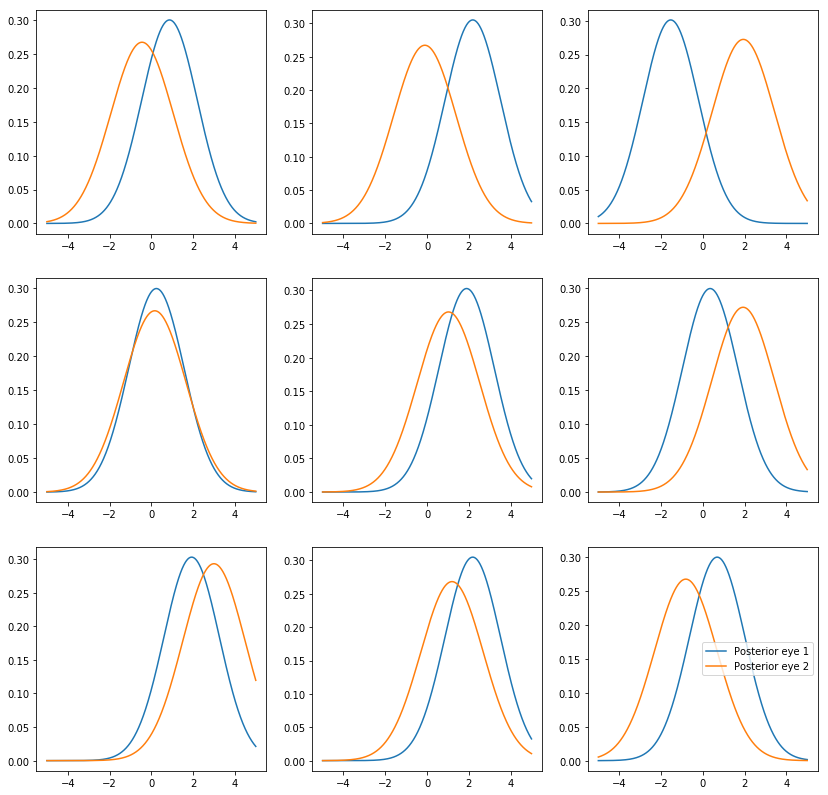

In [1932]:
s, p_sd = fitter.decode(data)

plt.figure(figsize=(14, 14))

for i, j in enumerate(np.arange(250, 475, 25)):
    plt.subplot(3, 3, i+1)
    plt.plot(s, p_sd[j, :, 0], label='Posterior eye 1')
    plt.plot(s, p_sd[j, :, 1], label='Posterior eye 2')
    
plt.legend()

In [1933]:
s = fitter.get_map_stimulus_timeseries(data[250:])

(0, 50)

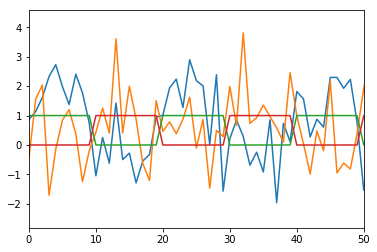

In [1938]:
plt.plot(s)
plt.plot(X[250:])
plt.xlim(0, 50)

In [1942]:
print(sp.stats.pearsonr(s[:, 0], X[250:, 0]))
print(sp.stats.pearsonr(s[:, 1], X[250:, 1]))

(0.5427647244478376, 1.4862389984275808e-20)
(0.39757668572927995, 6.767784179438292e-11)


In [1943]:
from sklearn import linear_model

In [1944]:
ols_model = linear_model.LinearRegression(fit_intercept=False)
ols_model.fit(data[:250], X[:250, 0])
s0 = ols_model.predict(data[250:])

ols_model.fit(data[:250], X[:250, 1])
s1 = ols_model.predict(data[250:])

In [1945]:
print(sp.stats.pearsonr(s0, X[250:, 0]))
print(sp.stats.pearsonr(s1, X[250:, 1]))

(0.4616046364614427, 1.3467338700409008e-14)
(0.3618494283298869, 3.778966851146866e-09)


In [1970]:
fitter = BinocularModelFitter()

results = []

for n_voxels in [5, 25, 50]:
    BinocularGenerativeModel(n_voxels=n_voxels)
    print(n_voxels)
    for voxel_noise in [0.5, 1, 2.5, 5]:
        print(voxel_noise)
        for ocular_noise in [0, 0.5, 1, 2.5, 5]:
            for run in range(1):
                
                data, X = bm.simulate_data(n_t=500, voxel_noise=voxel_noise, ocular_noise=ocular_noise, shared_noise=1.)

                # Fit van Bergen model on first half
                fitter.fit(data[:250], X[:250])
                
                # Fit OLS on first half
                ols_model1 = linear_model.LinearRegression(fit_intercept=False)
                ols_model1.fit(data[:250], X[:250, 0])
                
                ols_model2 = linear_model.LinearRegression(fit_intercept=False)
                ols_model2.fit(data[:250], X[:250, 1])
                
                # Predict second half with van Bergen model
                s_berg = fitter.get_map_stimulus_timeseries(data[250:])

                # Predict second half with OLS
                s1_ols = ols_model1.predict(data[250:])
                s2_ols = ols_model2.predict(data[250:])

                results.append({'ocular_noise':ocular_noise,
                                'voxel_noise':voxel_noise,
                                'n_voxels':n_voxels,
                                'run':run,
                                'r van_bergen eye 1':ss.pearsonr(X[250:, 0], s_berg[:, 0])[0],
                                'r van_bergen eye 2':ss.pearsonr(X[250:, 1], s_berg[:, 1])[0],
                                'r OLS eye 1':ss.pearsonr(X[250:, 0], s1_ols)[0],
                                'r OLS eye 2':ss.pearsonr(X[250:, 1], s2_ols)[0]}) 

5
0.5


/Users/gilles/miniconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


1
2.5
5
25
0.5
1
2.5
5
50
0.5
1
2.5
5


In [1974]:
results = pd.DataFrame(results)

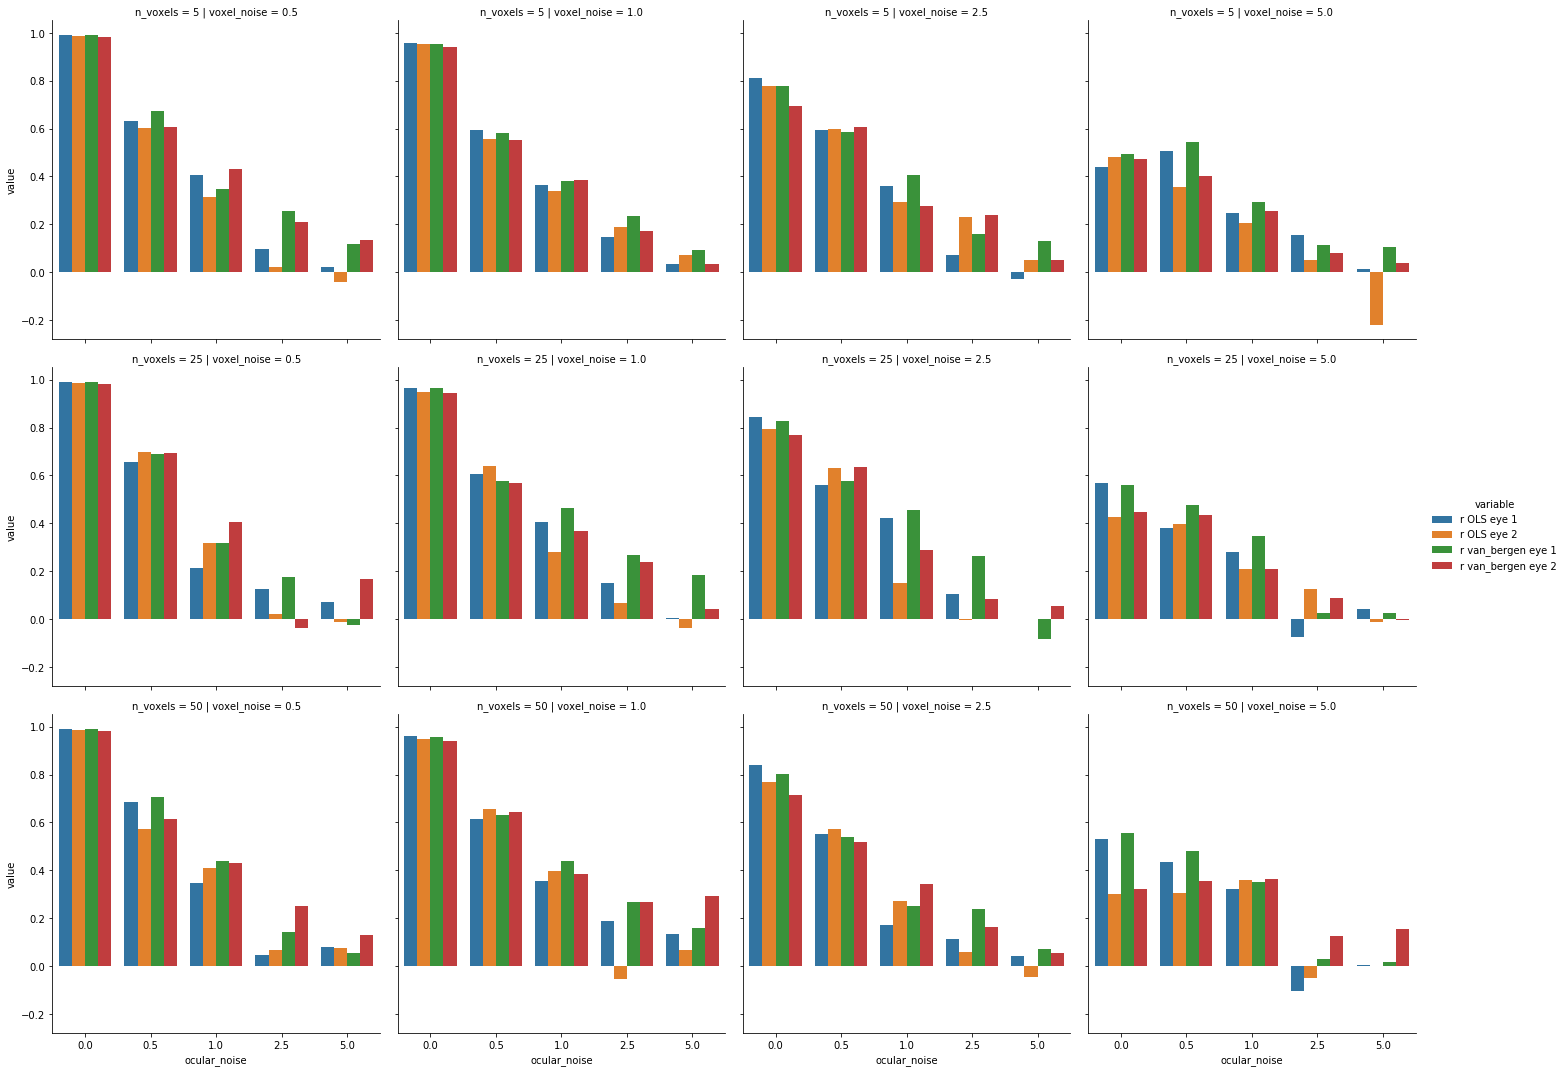

In [1977]:
sns.catplot('ocular_noise', 'value', 'variable', col='voxel_noise', kind='bar', row='n_voxels', data=results.melt(id_vars=['run', 'ocular_noise', 'voxel_noise', 'n_voxels']))

In [2011]:
tmp

improvement left eye  \
n_voxels voxel_noise ocular_noise run                         
5        0.5         0.0          0                0.000823   
                     0.5          0                0.042375   
                     1.0          0               -0.060845   
                     2.5          0                0.155860   
                     5.0          0                0.095870   
         1.0         0.0          0               -0.003780   
                     0.5          0               -0.012426   
                     1.0          0                0.019095   
                     2.5          0                0.085258   
                     5.0          0                0.058833   
         2.5         0.0          0               -0.034491   
                     0.5          0               -0.011715   
                     1.0          0                0.044859   
                     2.5          0                0.090685   
                     5.0          0                0.161080   
         5.0         0.0          0                0.056022   
                     0.5          0                0.038151   
                     1.0          0                0.042664   
                     2.5          0               -0.039435   
                     5.0          0                0.091105   
25       0.5         0.0          0                0.001154   
                     0.5          0                0.031312   
                     1.0          0                0.106135   
                     2.5          0                0.050790   
                     5.0          0               -0.095121   
         1.0         0.0          0                0.001200   
                     0.5          0               -0.029019   
                     1.0          0                0.059049   
                     2.5          0                0.117182   
                     5.0          0                0.180545   
         2.5         0.0          0               -0.015764   
                     0.5          0                0.018884   
                     1.0          0                0.032533   
                     2.5          0                0.157871   
                     5.0          0               -0.081238   
         5.0         0.0          0               -0.006955   
                     0.5          0                0.097216   
                     1.0          0                0.064661   
                     2.5          0                0.100077   
                     5.0          0               -0.016117   
50       0.5         0.0          0               -0.000834   
                     0.5          0                0.023355   
                     1.0          0                0.092549   
                     2.5          0                0.095839   
                     5.0          0               -0.025239   
         1.0         0.0          0               -0.003595   
                     0.5          0                0.014468   
                     1.0          0                0.079660   
                     2.5          0                0.078066   
                     5.0          0                0.025453   
         2.5         0.0          0               -0.037162   
                     0.5          0               -0.010598   
                     1.0          0                0.078628   
                     2.5          0                0.124569   
                     5.0          0                0.030996   
         5.0         0.0          0                0.023242   
                     0.5          0                0.048332   
                     1.0          0                0.026905   
                     2.5          0                0.133865   
                     5.0          0                0.014711   

                                       improvement right eye  
n_voxels voxel_noise ocular_noise run                         
5     

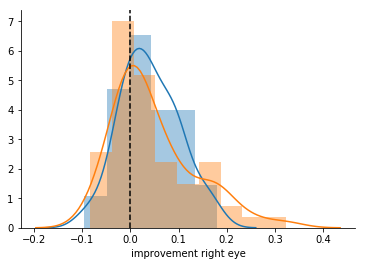

In [2034]:
sns.distplot(tmp['improvement left eye'])
sns.distplot(tmp['improvement right eye'])
plt.axvline(0.0, c='k', ls='--')
sns.despine()

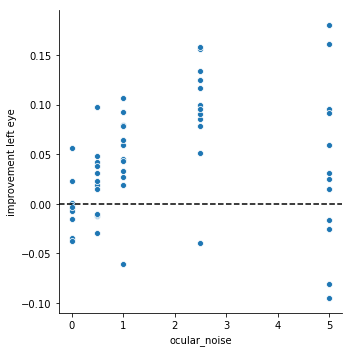

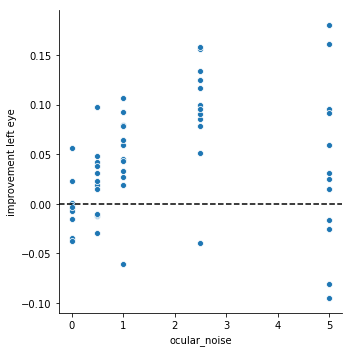

In [2018]:
tmp = results.pivot_table(index=['n_voxels', 'voxel_noise', 'ocular_noise', 'run'])

tmp1 = (tmp['r van_bergen eye 1']- tmp['r OLS eye 1']).to_frame('improvement left eye')
tmp2 = (tmp['r van_bergen eye 2'] - tmp['r OLS eye 2']).to_frame('improvement right eye')
tmp = tmp1.merge(tmp2, left_index=True, right_index=True).reset_index()

sns.relplot('ocular_noise', 'improvement left eye', data=tmp.reset_index())
plt.axhline(0, c='k', ls='--')
sns.relplot('ocular_noise', 'improvement left eye', data=tmp.reset_index())
plt.axhline(0, c='k', ls='--') 